# Task 1: Modeling and Predicting Customer Ratings
Team name: La Team

Team members: ALOUF Fares, KWAN Baldur Chin Man, MBELOSON Riana Valera, WANG Dingjia


## Introduction:

In this project, we aim to predict customer satisfaction ratings based on textual reviews for various businesses in North America. Each review is accompanied by a satisfaction rating ranging from 1 (bad) to 5 (good). Alongside the review texts, additional information about each customer and business is also available, which could potentially enhance the prediction accuracy.

We start by preprocessing the data to clean and normalize the textual reviews. This step includes removing stopwords and transforming the text into numerical features suitable for machine learning models. After preprocessing, we split the provided training data into two subsets: a training set and a validation set. This split allows us to train the models and evaluate their performance before making predictions on the test set.

We experiment with several machine learning techniques, including Logistic Regression, Support Vector Classifier (SVC), Multi-Layer Perceptron (MLP), and Bidirectional Long Short-Term Memory (BLST) networks. Among these models, SVC and BLST demonstrate superior performance in terms of prediction accuracy. Therefore, we conduct an in-depth diagnostic analysis of these models to fine-tune their parameters and improve their performance further.

Finally, we use the optimized models, particularly the SVC and BLST, to predict the customer satisfaction ratings on the test set. By training these models on the entire training dataset, we aim to achieve the best possible predictions for the given reviews.


In [17]:
import pandas as pd # for manipulate data frame
import matplotlib.pyplot as plt # for plots
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import Sequential
import random


from sklearn.feature_extraction.text import CountVectorizer # for transforming text into vector of count.
from sklearn.feature_extraction.text import TfidfTransformer  # for term-frequency-inverse document-frequency transformation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
import joblib
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassPredictionError
from IPython.display import display, Markdown

## Data analysis
### Data Preprocessing
We start by reading the training data and examining the structure of the data set.

In [42]:
# loading training data

data_train = pd.read_csv("ATML2024_reviews_train.csv")

In [3]:
display(Markdown(f"Our data frame is {data_train.shape[0]} $\\times$ {data_train.shape[1]}"))

Our data frame is 1050000 $\times$ 9

As we can see, the large size of the data may hinder the use of advanced models such as transformers, especially on local machines with average specifications.

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1050000 non-null  int64 
 1   user_id      1050000 non-null  object
 2   business_id  1050000 non-null  object
 3   rating       1050000 non-null  int64 
 4   useful       1050000 non-null  int64 
 5   funny        1050000 non-null  int64 
 6   cool         1050000 non-null  int64 
 7   text         1050000 non-null  object
 8   date         1050000 non-null  object
dtypes: int64(5), object(4)
memory usage: 72.1+ MB


Upon examining the structure of the data, we observe that it contains an ID column and 8 variables. For our prediction task, the key variables are `text`, which represents the customer's review, and `rating`, an ordinal variable ranging from 1 (bad) to 5 (good). Before plotting the distribution of responses, we will make sure to remove duplicates and NA values.

In [5]:
data_train=data_train.dropna().drop_duplicates().reset_index(drop=True)
data_train.head()

,id,user_id,business_id,rating,useful,funny,cool,text,date
0,0,gRWsscMiClFGIh2YUjNInT,Ab1ejQzv4eJRLgAlj7tzKT,5,1,0,0,"Sometimes you just want a cup of coffee, in a ...",2013-12-22 23:45:01
1,1,Q3RXWVFtLo4I7MC85ELPh7,QkRhOowLAGVZC5gn4RLkjH,5,1,0,0,Mr. Clyde stopped at our house and asked us if...,2020-02-11 01:00:32
2,2,AD2z6qhmVcRJkywa1KsEFG,ADWVkizi8gKjj07mn8NiMe,4,0,0,0,One of my favorite places to grab a quick bit ...,2014-05-28 19:05:26
3,3,A8HQot2boCpoPIThfHV5iy,wkk30dWY49cSiDU3FKg8FH,5,0,1,0,"Wow, this place is huge! Life size aquarium an...",2014-01-20 23:42:44
4,4,Q7UzjD01YnimUOsvAEQ7JK,wUjnssL0bJIEqdqJs8M0GV,5,0,0,0,I ordered 3 large pizzas and wings for my fam...,2020-01-29 00:20:34


Next, we plot the distribution of customer ratings. The bar plot below clearly depicts a class imbalance, with the mode being at 5. Specifically, 46.18% of the ratings are 5. In a perfectly balanced dataset with five classes, we would expect around 20% of each class. This is an important observation because a "bad model" that always predicts 5 could achieve an accuracy of approximately 45 to 50%, despite the presence of five classes.

In [6]:
# Calculate the total number of ratings
total_ratings = data_train['rating'].count()

# Calculate the number of 5's in the rating variable
count_of_fives = data_train[data_train['rating'] == 5].count()['rating']

# Calculate the percentage of 5's
percentage_of_fives = (count_of_fives / total_ratings) * 100

# Print the result
print(f"The percentage of 5's in the rating variable is {percentage_of_fives:.2f}%")


The percentage of 5's in the rating variable is 46.18%


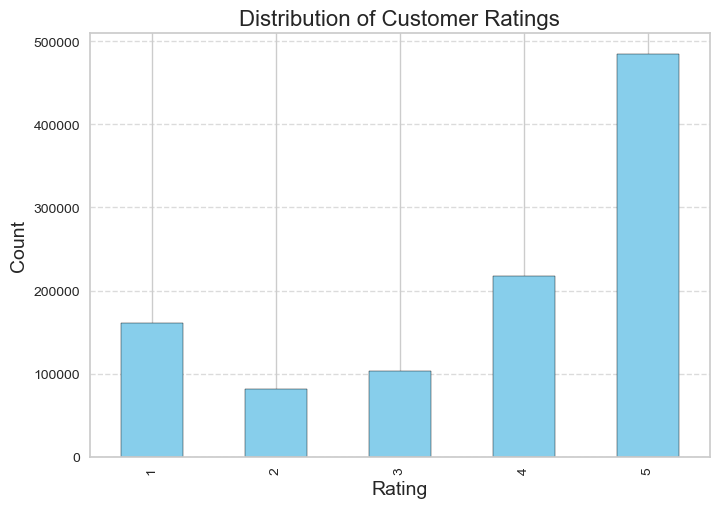

In [7]:
# Plot the bar plot with customizations
rating_counts = data_train.rating.value_counts().sort_index()
rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add a title and labels
plt.title('Distribution of Customer Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Let's print some examples of text to observe its structure.


In [8]:
#example of data
print(data_train["text"][0])  # multiple space
print(data_train["rating"][0])
print()
print(data_train["text"][1])
print(data_train["rating"][1])

Sometimes you just want a cup of coffee, in a quiet place, with no conversation, loud music, BS, etc. and Portland Brew is it.  I would normally go to Frothy, but it's normally so freaking loud and full of  Belmont kids, Portland is now my default.  I also appreciate that most of the time, when i get my normal iced coffee with soy, that I'm given the soy to pour my preferred amount.  It's the little things, i guess.

Thumbs up.
5

Mr. Clyde stopped at our house and asked us if we had any tree removal work for him. We said that we had a huge, dying/dead palm tree and needed it removed. Clyde and Sons Tree Service was working at a neighbor's house, so we saw that they were legitimate. They came back to our house the next week with their equipment and performed the job at the time and price we negotiated. He climbed up the tree and did an excellent, careful job and removed the 4500 lb.tree which was quite close to our house. They also ground up the tree stump, which was double in size, be

We observe that the text is in English and needs to be preprocessed before fitting it into a model. The preprocessing steps include:

- Removing unnecessary spaces.
- Removing stopwords.
- Removing undesirable characters.
- Replacing capital letters with lowercase letters.

The goal of these steps is to reduce the complexity of sentences (unnecessary spaces, undesirable characters), standardize them (lowercase letters, unnecessary spaces), and maximize the variance between them by removing stopwords.



In [9]:
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

# Download NLTK stopwords (if not already downloaded)
nltk.download('stopwords')

replace_space = re.compile(r'[/(){}\[\]\|@,;]')
bad_symbols = re.compile(r'[^0-9a-z #+_]')
stop_words = set(stopwords.words('english')) 
def preprocess_text(text):
    """
    Function to preprocess and clean the text.
    
    Parameters:
    - text (str): Input text to be preprocessed.
    
    Returns:
    - str: Preprocessed text.
    """
    # HTML decoding
    text = BeautifulSoup(text, "lxml").text
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace symbols defined in replace_space with space
    text = replace_space.sub(' ', text)
    
    # Remove symbols not in the allowed set [0-9a-z #+_]
    text = bad_symbols.sub(' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading and trailing spaces
    text = text.strip()
    
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    return text

# Example usage
dashed = "-" * 60
print(dashed)
print(dashed)
sample_text = "The food at this restaurant was absolutely amazing! The service was top-notch and the ambiance was perfect for a relaxing evening. Highly recommended! "
print(sample_text)
print(dashed)
cleaned_text = preprocess_text(sample_text)
print(cleaned_text)
print(dashed)
print(dashed)


------------------------------------------------------------
------------------------------------------------------------
The food at this restaurant was absolutely amazing! The service was top-notch and the ambiance was perfect for a relaxing evening. Highly recommended! 
------------------------------------------------------------
food restaurant absolutely amazing service top notch ambiance perfect relaxing evening highly recommended
------------------------------------------------------------
------------------------------------------------------------


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fares\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Formatting training data

In [10]:
data_train["text"] = data_train["text"].apply(preprocess_text) 

C:\Users\Fares\AppData\Local\Temp\ipykernel_31320\2817685691.py:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
C:\Users\Fares\AppData\Local\Temp\ipykernel_31320\2817685691.py:23: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


After preprocessing the text data, we will print two examples with their respective ratings.

In [11]:
print(data_train["text"][3])
print(data_train["rating"][3])
print()
print(data_train["text"][1])
print(data_train["rating"][1])

wow place huge life size aquarium ferris wheel also sports departments individualized customer service great asked three different times help looking golf balls place sports mention guns
5

mr clyde stopped house asked us tree removal work said huge dying dead palm tree needed removed clyde sons tree service working neighbor house saw legitimate came back house next week equipment performed job time price negotiated climbed tree excellent careful job removed 4500 lb tree quite close house also ground tree stump double size half tree already cut years past old stump left next present tree felt price reasonable extent job would hesitate call clyde sons tree service removal tree stump competent hardworking gentlemen thank guys
5


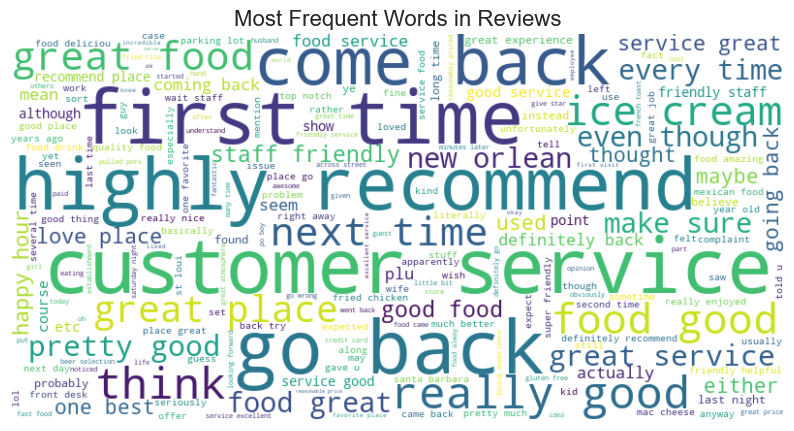

In [12]:
from wordcloud import WordCloud

text = ' '.join(data_train['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Reviews', fontsize=16)
plt.show()

## Model Fitting
Now that we have effectively prepared the data, we will proceed with a classic machine learning pipeline. This pipeline includes splitting the dataset into training and validation sets, comparing candidate models using cross-validation, and fine-tuning them with grid search.

**Data splitting (70% training, 30 % test)**

In [13]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data_train["text"],  
                                                    data_train["rating"],  
                                                    test_size=0.3,
                                                    shuffle=True,
                                                   random_state =2000)

In [14]:
# Define folds
folds = KFold(n_splits=5, shuffle=True, random_state=1234)

# Model

### Multinomial logistic regression

Multinomial logistic regression is a discriminative model used for classification problems where the dependent variable has more than two classes. This method predicts the probability of each class given a set of features, using the maximum likelihood estimation to adjust the model parameters. 
The goal of multinomial logistic regression is to discern and differentiate between different text reviews by identifying which features (e.g., words or phrases) contribute the most information for accurate classification. The model does this by estimating the contribution of each feature to the likelihood of each class, thereby allowing for the prediction of the most probable class for a given set of features.

**Pipeline description**

In the `logit_pipe` pipeline, the `CountVectorizer` is set with `max_df`=0.75 to filter out overly common terms, reducing noise and focusing on more meaningful features. The `TfidfTransformer` is configured with `sublinear_tf=True`, which applies logarithmic scaling to term frequency, diminishing the impact of very frequent terms and potentially improving model performance. For `LogisticRegression`, the `solver`="saga" is chosen for its efficiency with large datasets and its ability to handle both L1 and L2 regularization. Additionally, `max_iter`=1500 ensures that the solver has enough iterations to properly converge, enhancing the overall reliability and effectiveness of the model. Due to the expensiveness of grid search, these values were chosen on best practices


In [36]:
# Define the pipeline with L2 regularization
logit_pipe = Pipeline([
    ('vect', CountVectorizer(max_df=0.85, ngram_range=(1, 2))),  # Including bigrams
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('logit', LogisticRegression(solver='saga', max_iter=1500, penalty='l2', C=1.0))
])

In [37]:
logit_pipe.fit (x_train, y_train)
print(f"Training Accuracy:", logit_pipe.score(x_train, y_train))
print(f"Testing Accuracy:", logit_pipe.score(x_test, y_test))

Training Accuracy: 0.8542897959183674
Testing Accuracy: 0.7062063492063492


In [46]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'tfidf__use_idf': [True],
    'logit__C': [0.1, 1, 10],  # Regularization strength
    'logit__penalty': ['l2', 'l1']  # L2 or L1 regularization
}


In [48]:
# Define the GridSearchCV
grid_search = GridSearchCV(logit_pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit (x_train, y_train)

### Linear SVC (Best Model)

The Support Vector Classifier (SVC) shares similarities with logistic regression but uses a geometric approach. SVC predicts classes based on input features, such as text reviews, without relying on distributional assumptions. Both models aim to find linear decision boundaries, which become hyperplanes in high-dimensional spaces, to classify data effectively.

The key difference lies in handling hyperplanes. Logistic regression models probabilities and parameter estimation without focusing on margin maximization. In contrast, SVC maximizes the margin between classes, creating a robust and well-generalized decision boundary, which helps mitigate overfitting.

**Wide gridsearch**
We will start with a `GridSearchCV` that allows us to find the best parameters among a set of candidates. As the data is very large, the search will take a significant amount of time to be completed. Thus we ran it once, and we saved the parameters. In the following cells we kept the initial code used to find the best model, however, in the later cells of the section we will manually fit the model with the best parameters found and that scored the highest performance on kaggle.

**Wide gridsearch**

In [18]:
# Define grid
my_grid = {
    'SVC__C': [0.1,0.5,1],
    "SVC__loss":["squared_hinge"],
    'vect__ngram_range' :[(1, 2)]
}

# Define Grid
SVC_cv = GridSearchCV(
    estimator = SVC_pipe ,
    param_grid=my_grid,
    scoring="accuracy",
    cv=folds,
    n_jobs = 1,
    verbose = 10
)

In [19]:
SVC_cv.fit (x_train, y_train) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START SVC__C=0.1, SVC__loss=squared_hinge, vect__ngram_range=(1, 2)


In [36]:
# MEAN TIME CALCULATION FOR FIT

time_iteractions = SVC_cv.cv_results_['mean_fit_time'] + SVC_cv.cv_results_['mean_score_time']

# Calculate the average time overall
time_iteractions.mean()

264.4357870896657

In [37]:
SVC_top= pd.DataFrame(SVC_cv.cv_results_)

SVC_standing = SVC_top.sort_values(by='rank_test_score')

# Print the top 5 rows
SVC_standing.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVC__C,param_SVC__loss,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,172.969057,10.805877,32.038364,3.048741,0.1,squared_hinge,"(1, 2)","{'SVC__C': 0.1, 'SVC__loss': 'squared_hinge', ...",0.698007,0.695279,0.698367,0.697136,0.698959,0.697550,0.001280,1
1,230.466705,16.356862,38.505910,4.630644,0.5,squared_hinge,"(1, 2)","{'SVC__C': 0.5, 'SVC__loss': 'squared_hinge', ...",0.694721,0.691497,0.694435,0.693293,0.694517,0.693693,0.001206,2
2,277.725392,10.956571,41.601933,6.705692,1,squared_hinge,"(1, 2)","{'SVC__C': 1, 'SVC__loss': 'squared_hinge', 'v...",0.689673,0.686517,0.689558,0.688197,0.689599,0.688709,0.001225,3


In [ ]:
print("SVC best model from CV:", SVC_cv.best_params_)

In [33]:
from sklearn.svm import LinearSVC
SVC_pipe = Pipeline([('vect', CountVectorizer(max_df=0.75, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ("SVC", LinearSVC(C=0.1, loss='squared_hinge',class_weight="balanced",max_iter=2500,dual=True))
])


In [34]:
SVC_pipe.fit(x_train,y_train)


print(f"Training Accuracy:", SVC_pipe.score(x_train, y_train))
print(f"Testing Accuracy:", SVC_pipe.score(x_test, y_test))

Training Accuracy: 0.8555700680272109
Testing Accuracy: 0.7000730158730158


## Model Fitting - Neural Language Models  
In this section, we will explore language models based on neural network architecture. This part was especially challenging because of the computational requirements, most iterations had to run overnight. We first started by a Multi-Layer Perceptron which follows a relatively simple architecture that served as a starting point to be improved upon. In fact this model had the poorest performance compared to the others we used.

### TextVectorization and Embedding layers:

To prepare text data for model training, we will preprocess the text reviews for a neural network. We will set parameters such as the maximum vocabulary size, which limits the number of unique tokens, and the sequence length, which defines the fixed length of output sequences. Additionally, we will standardize the text by converting it to lowercase and removing punctuation. The preprocessing steps include converting words to integer indices, ensuring sequences are of fixed length, and adapting the tokenizer to the training data to learn the vocabulary. After preprocessing, we will create an embedding layer for the neural network using TensorFlow's Keras API.




In [35]:
max_vocab = 50000      
sequence_length = 100
vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',
                                           output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(x_train)

In [20]:
vocab_train=np.array(vectorize_layer.get_vocabulary())

This embedding layer will be part of a neural network model and will transform the integer-encoded text data into dense vectors, which can then be fed into further layers of the network for learning and prediction.

In [21]:
embedder = layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=5,
                            embeddings_initializer='uniform')

## Multi-Layer Perceptron (MLP)

The Multilayer Perceptron (MLP) is a type of artificial neural network that consists of multiple layers of interconnected neurons. It is represented as a direct acyclic graph. where each neuron in the hidden layers and the output layer typically applies an activation function to its weighted sum of inputs. the model  learns by minimizing a predefined loss function, which measures the difference between the predicted outputs and the true outputs in the training data.

We set first , the dimension of the dense embedding vectors and the number of output classes for classification. Then we create MLP_model using Sequential API, which allows you to build a model layer by layer.

In [23]:
embedding_dim=50
n_classes=6
MLP_model = Sequential([
    layers.Input(shape=(1,), dtype="string"),
    vectorize_layer,
    layers.Embedding(input_dim=len(vocab_train), output_dim=embedding_dim,
                     embeddings_initializer='uniform'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
], name="MLP_model")

MLP_model.summary()

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 100, 50)           2500000   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 39

Adam optimizer is chosen for its adaptive learning rate and efficient computation. Also, Loss Function: Sparse categorical cross-entropy is chosen for its suitability for multi-class classification with integer labels. And, Accuracy metrics is chosen for its straightforward interpretability and relevance to classification tasks.

In [22]:
MLP_model.compile(optimizer=optimizers.Adam(),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

Here we train the model and save the weights 
 we set epochs=5 which  means the model will iterate over the training data five times, adjusting its weights in each iteration to minimize the loss function and improve accura

In [ ]:
epochs = 2
history_MLP = MLP_model.fit(x_train, y_train, validation_data=(x_test, y_test),
                            batch_size=64, epochs=epochs)

**Notice**

Training a model for too many epochs can lead to overfitting. Overfitting occurs when a model learns the training data too well, including its noise and outliers, which results in poor generalization to new, unseen data.
We set a narrow  a range of possible values for the hyperparameter for computation constraint. 
We are going to look where the validation accuracy start decreasing. Also we include a dropout layer as part of our model architecture which is a regularization technique commonly used to prevent overfitting in neural networks. Basicaly, it randomly sets a fraction of input units to zero during training.



In [ ]:
#!pip install keras-tuner

import keras_tuner as kt

#Define the model-building function
def build_model(hp):
    embedding_dim = hp.Choice('embedding_dim', values=[50, 100])
    dense_units = hp.Choice('dense_units', values=[64, 128])
    dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3])
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), dtype="string"),
        vectorize_layer,
        tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embedding_dim),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
#Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='./tuner',
                     project_name='text_classification')

# Perform the hyperparameter search
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:")
print(best_hyperparameters)

# Evaluate the best model
loss, accuracy = best_model.evaluate(x_test, y_test)
print("Test accuracy:", accuracy)


In [26]:
loss, accuracy = MLP_model.evaluate(x_test, y_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

9844/9844 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.6893 - loss: 0.7441
Loss:  0.7459400296211243
Accuracy:  0.6889523863792419


Looking at the results, we notice an accuracy of 0.6889, which is lower than the accuracy of our SVC.

## BLSTM

To more accurately capture the sentiment of the text and improve upon a simple Multi-Layer Perceptron (MLP), we need a model that can capture the context and long-range dependencies in sequential data. The bidirectional variant of Long Short-Term Memory (BiLSTM) processes the input sequence in both forward and backward directions, effectively capturing information from both past and future contexts simultaneously. Each LSTM cell maintains an internal state (cell state) that can selectively retain or forget information over time, making it well-suited for modeling sequences with long-range dependencies.

The input gate controls how much new information is allowed to enter the cell state. The forget gate decides which information to discard from the cell state. The output gate determines the output of the cell based on the current input and the cell state


In [24]:
embedding_dim=50

# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

BLSTM_model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.Bidirectional(layers.LSTM(64), merge_mode='concat'),
    layers.Dense(n_classes, activation='softmax')
], name="BLSTM_model")



In [25]:
BLSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [ ]:
epochs = 6
history_lstm = BLSTM_model.fit(x_train, y_train, validation_data=(x_test, y_test),
                               batch_size=64, epochs=epochs)

In [ ]:

# Set stop_training to True
BLSTM_model.stop_training = True

# Save the model in TensorFlow SavedModel format
BLSTM_model.save('BLSTM_model', save_format='tf')

In [31]:
# Load the saved model
loaded_model = tf.keras.models.load_model('BLSTM_model')

In [32]:
test_loss, test_acc = BLSTM_model.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


9844/9844 [==============================] - 121s 12ms/step - loss: 0.7381 - accuracy: 0.6901
Test Loss: 0.7380744814872742
Test Accuracy: 0.6901269555091858


## Model diagnostic

A classification report is a performance evaluation tool that provides a detailed analysis of the model's predictive performance. It includes several key metrics that help to understand how well the model is performing, especially in terms of its ability to correctly classify instances of different classes.

Precision is the ratio of correctly predicted positive observations to the total predicted positives.
Recall is the ratio of correctly predicted positive observations to all observations in the actual class.
The F1-score is the harmonic mean of precision and recall.
Support is the number of actual occurrences of the class in the dataset.

we also use  visualizers which enhances the interpretability and understanding of model's performance.
specifically, ClassPredictionError visualizer from Yellowbrick is an effective way to understand where the model is making mistakes. This visualizer creates a bar chart that shows the distribution of predicted classes for each actual class, making it easier to see misclassifications.

**Classification report: SVC**

In [41]:
# SVC_pipe.fit(x_train,y_train)
y_hat = SVC_pipe.predict(x_test)


print(f"Training Accuracy:", SVC_pipe.score(x_train, y_train))
print(f"Testing Accuracy:", SVC_pipe.score(x_test, y_test))

Training Accuracy: 0.8557020408163265
Testing Accuracy: 0.700047619047619


In [58]:
class_names = [str(label) for label in SVC_pipe.classes_]
print(classification_report(y_test, y_hat, target_names=class_names))

              precision    recall  f1-score   support

           1       0.87      0.94      0.90     48324
           2       0.84      0.81      0.82     24718
           3       0.82      0.83      0.83     30955
           4       0.78      0.68      0.73     65608
           5       0.88      0.91      0.89    145395

    accuracy                           0.85    315000
   macro avg       0.84      0.83      0.84    315000
weighted avg       0.85      0.85      0.85    315000



Overall, the analysis indicates that the classifier performs well in predicting rating scores 1 and 5, with high precision and recall values. However, it struggles with rating scores 3, 4 and 2, especially in terms of recall, where it fails to identify a significant portion of the instances correctly. With 2 , 3 it might be due to imbalanced data between the classes where 2 and 3 have the lowest proportion but for 4 it is likely due to the fact that It's difficult to capture the nuances between 4 and 5. as they are close on the rating scale and might share similar characteristics in the text reviews. 

In [60]:
report = classification_report(y_test, y_hat, target_names=SVC_pipe.classes_, zero_division=1, output_dict=True)

# Extract only the average scores
average_scores = report['weighted avg']

print("Average Precision:", average_scores['precision'])
print("Average Recall:", average_scores['recall'])
print("Average F1-Score:", average_scores['f1-score'])

Average Precision: 0.8487325815021105
Average Recall: 0.8512603174603175
Average F1-Score: 0.8489299464926877


On average, these aggregated metrics suggest that the model has performed consistently well across all classes, with high precision, recall, and F1-score values

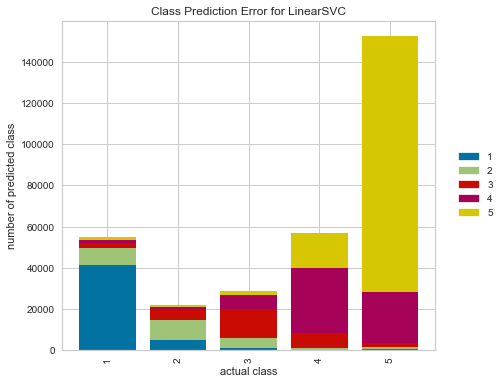

In [63]:
from yellowbrick.classifier import ClassPredictionError

# Initialize the visualizer without specifying classes
visualizer = ClassPredictionError(SVC_pipe)

# Fit and score the visualizer
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)

# Draw/show/present the visualizer
visualizer.show();


The model architecture might not be complex enough to capture the nuances between rating scores 2 and 3 or 4 and 5

Bidirectional Long Short-Term Memory (LSTM) networks tackle the challenge of managing long-term dependencies in sequential data by dividing the problem into two sub-problems: removing unnecessary information from the context and adding information relevant to future decision-making. They achieve this by introducing an explicit contextual layer in addition to the recurrent hidden layer, and by using specialized neural units equipped with mechanisms to control the flow of information within the network. These gates, implemented via extra weights, regulate the input, the preceding hidden layer and the preceding contextual layers sequentially. Compared with basic recurrent units, the additional complexity introduced by this method is the context vector as both input and output.

In [38]:
# Predict using each model
# Model 1: Logistic Regression
y_pred_logit = logit_pipe.predict(x_test)

# Model 2: SVC
y_pred_SVC = SVC_pipe.predict(x_test)

# Model 3: BLSTM
y_pred_BLSTM = np.argmax(BLSTM_model.predict(x_test), axis=1)


9844/9844 [==============================] - 79s 8ms/step


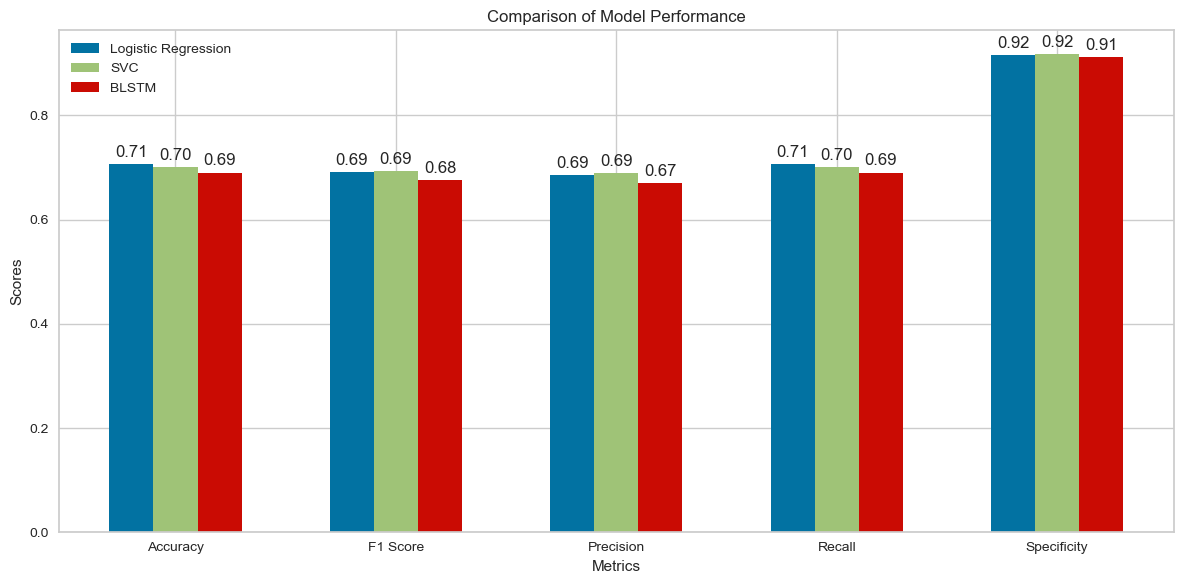

In [40]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate specificity for each class and then average
    specificity_per_class = []
    for i in range(cm.shape[0]):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - cm[i, i]
        fn = np.sum(cm[i, :]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)
        
    specificity = np.mean(specificity_per_class)
    
    return accuracy, f1, precision, recall, specificity

# Calculate metrics for each model
logit_metrics = calculate_metrics(y_test, y_pred_logit)
SVC_metrics = calculate_metrics(y_test, y_pred_SVC)
BLSTM_metrics = calculate_metrics(y_test, y_pred_BLSTM)

# Metrics names
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'Specificity']

# Metrics for each model
metrics_logit = list(logit_metrics)
metrics_SVC = list(SVC_metrics)
metrics_BLSTM = list(BLSTM_metrics)

# Data for plotting
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
bars_logit = ax.bar(x - width, metrics_logit, width, label='Logistic Regression')
bars_SVC = ax.bar(x, metrics_SVC, width, label='SVC')
bars_BLSTM = ax.bar(x + width, metrics_BLSTM, width, label='BLSTM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add bar labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars_logit)
add_labels(bars_SVC)
add_labels(bars_BLSTM)

fig.tight_layout()
plt.show()


### Test data preparation

In [45]:
# Load the data test
data_test = pd.read_csv("ATML2024_reviews_test.csv")

In [49]:
data_test=data_test.dropna().drop_duplicates().reset_index(drop=True)
data_test.head()

,id,user_id,business_id,useful,funny,cool,text,date
0,0,gvBtin5OThPeN_bnTEurnf,ghjD0PwEk01lg3xSEIU7lY,0,0,0,The baked goods are absolutely spot-on. Servic...,2012-10-24 23:28:20
1,1,ABNGyzmO1C-lKV5N3eofwt,gbLzi3rXs4NNiCx0o8kaBY,0,3,1,I haven't seen so many Brooklyn shirts in one ...,2013-01-13 18:36:36
2,2,AoXvd9IJkHaeMy4jVuWsy3,AopiT0727RWiuJe6qGnXB0,1,0,0,Sushi was very good. Service was poor. Ordered...,2020-10-29 01:03:12
3,3,Q8bhoPj9Ft22ignaL2mxfW,AVeoh8aeh4ksZmVz1FTJbj,0,0,0,"Great burgers, stoked they had GF buns and gro...",2019-05-12 00:26:48
4,4,QYP7NLVyfNOdCWFCqvOTmX,A0fLuSkNXwfBVQygQFEpN6,0,0,0,"Fantastic place! Absolutely love crepes, and b...",2017-02-28 03:31:16


In [ ]:
# Preprocess
data_test["text"] = data_test["text"].apply(preprocess_text) 

**Model fitting over the whole dataset:**

**SVC prediction**

In [51]:
# train with SVC
SVC_pipe.fit (data_train["text"], data_train["rating"])

#predicted value
y_pred2 = SVC_pipe.predict(data_test["text"])

**Save prediction in data_frame**

In [52]:
solution5 =data_test[['id']]  # for SVC
solution5 = solution5.assign(rating=y_pred2)    # for SVC

solution5.to_csv("solution.csv", index=False)

## Conclusion:

The Support Vector Classifier (SVC) model performs well on text classification tasks due to its ability to capture complex patterns and contextual information from the text. SVC is effective because it can handle high-dimensional data and find the optimal separating hyperplane, which is crucial for distinguishing between different satisfaction ratings. Bidirectional Long Short-Term Memory (BLSTM) models, on the other hand, excel at understanding sequential dependencies and context within the text, making them particularly suited for processing natural language.

However, neural network models like BLSTM tend to overfit, which necessitates performing a grid search for hyperparameter tuning to mitigate this issue. This process is essential but computationally expensive, especially for high-dimensional text data. Similarly, the Multi-Layer Perceptron (MLP) struggles to capture the contextual nuances of the text compared to more sophisticated models like BLSTM.

Our analysis revealed that the three methods—SVC, BLSTM, and MLP—produced very similar results across all metrics. Although further fine-tuning could potentially improve their performance, it is computationally costly. Additionally, while transformer-based methods, such as BERT and GPT, could offer significant improvements in handling complex text data, we lacked the computational resources to implement them in this study.

On the test set, the SVC model slightly outperformed the others, demonstrating marginally better accuracy and robustness. Despite the computational challenges and resource constraints, these findings highlight the effectiveness of traditional and neural network approaches in text classification tasks.